# Final Evaluation of CRF, CNN, and Transformer NER Models

## 1. Introduction

This notebook presents the final evaluation of three trained Named Entity Recognition (NER) models developed for environmental scientific text. The models represent three distinct architectures:

- A Conditional Random Field (CRF) model trained on token-level BIO labels  
- A SpaCy CNN-based pipeline using a `tok2vec` and Maxout encoder  
- A SpaCy transformer-based pipeline using a pretrained BERT variant  

All models were trained on automatically annotated data using curated environmental vocabularies. Evaluation is conducted on a held-out test set of unseen sentences. The goal is to compare the three models both quantitatively and qualitatively in terms of:

- Overall and per-entity precision, recall, and F1 scores  
- Performance differences across entity categories  
- Span-level predictions on naturalistic input text  

This notebook provides a direct comparison of the final versions of each model, with accompanying analysis to support conclusions about generalisation and deployment readiness.


## 2. Loading Test Data and Final Models

The evaluation in this notebook uses a single `.spacy` test set containing preprocessed `Doc` objects. This set is compatible with both SpaCy pipelines and CRF token-based evaluation.

This section loads the required dependencies, the saved test data, and the three final models.


### 2.1 Define Paths and Import Dependencies

In [8]:
from pathlib import Path
import joblib
import pandas as pd
import json

import matplotlib.pyplot as plt

import spacy
from spacy.lang.en import English
from spacy.scorer import Scorer
from spacy.tokens import Span
from spacy.training.example import Example
from spacy.tokens import DocBin

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import train_test_split

from collections import defaultdict, Counter

# Define path to data files
SPACY_DATA_PATH = Path("../data/spaCy/")

TEST_DATA_PATH = Path("../data/spaCy/test.spacy")
CRF_JSONL_PATH = Path("../data/json/training_data.jsonl")

CRF_MODEL_PATH = Path("../models/crf/final_crf_model.joblib")
CNN_MODEL_PATH = Path("../models/spaCy/cnn_best/model-best")
TRANSFORMER_MODEL_PATH = Path("../models/spaCy/transformer_2/model-best")

### 2.2 Load Final Models

Each model is loaded from its saved location. These models were selected as the best-performing configurations from earlier experimentation.


In [3]:
# Load CRF model
crf_model = joblib.load(CRF_MODEL_PATH)

# Load SpaCy CNN model
cnn_model = spacy.load(CNN_MODEL_PATH)

# Load SpaCy Transformer model
transformer_model = spacy.load(TRANSFORMER_MODEL_PATH)

### 2.3 Load Test Documents

The test set is loaded from disk in SpaCy's `DocBin` format and converted to a list of `Doc` objects. The CNN model's vocabulary is used for consistency during deserialisation.

The resulting list of documents is stored in `test_examples`.

In [4]:
def load_test_data(path):
    doc_bin = DocBin().from_disk(path)
    return list(doc_bin.get_docs(cnn_model.vocab))

test_examples = load_test_data(TEST_DATA_PATH)

## 3. Inference and Prediction Extraction
This section runs inference on the held-out test set using all three final models: CRF, CNN, and Transformer. Each model generates predicted entity spans, which are compared against the gold-standard annotations for quantitative evaluation.

To ensure fairness, all predictions are evaluated using strict character span matching. This means an entity is only counted as correct if the predicted start and end character offsets exactly match the gold annotation. This approach ensures consistency between models, regardless of the tagging format used internally.

### 3.1 Feature Extraction and Test Set Preparation for CRF
The CRF model operates on handcrafted features extracted at the token level. These features were used during training and are reused during inference to ensure consistency.

In [5]:
def word2features(sentence, i):
    word = sentence[i][0]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }

    if i > 0:
        prev_word = sentence[i - 1][0]
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sentence) - 1:
        next_word = sentence[i + 1][0]
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
        })
    else:
        features['EOS'] = True

    return features

def sentence_to_features(sentence):
    return [word2features(sentence, i) for i in range(len(sentence))]

Each token is represented by a combination of lexical, morphological, and contextual features. These include lowercase forms, suffixes, casing, digit checks, and surrounding token properties.

The CRF model was trained using BIO-format labels on a CoNLL-style dataset. Because this differs from the `.spacy` format used by the CNN and Transformer models, the CRF-compatible test set is reconstructed directly from the original `.jsonl` file. This step ensures that tokenisation and label alignment remain consistent with what the CRF model was trained on.

In [6]:
def jsonl_to_conll(jsonl_path):
    nlp = spacy.blank("en")
    conll_data = []
    with open(jsonl_path, "r", encoding="utf8") as f:
        for line in f:
            data = json.loads(line)
            text = data["text"]
            entities = data.get("label", [])

            doc = nlp(text)
            tags = ["O"] * len(doc)
            for start_char, end_char, label in entities:
                for token in doc:
                    if token.idx >= start_char and token.idx < end_char:
                        tag = f"I-{label}"
                        if token.idx == start_char:
                            tag = f"B-{label}"
                        tags[token.i] = tag

            sentence = [(token.text, tags[token.i]) for token in doc]
            conll_data.append(sentence)

    return conll_data

In [7]:
conll_data = jsonl_to_conll(CRF_JSONL_PATH)
train_data, temp_data = train_test_split(conll_data, test_size=0.2, random_state=42)
val_data, test_data_for_crf = train_test_split(temp_data, test_size=0.5, random_state=42)

The function creates a list of token-label pairs for each sentence, where tokens are derived from SpaCy's default English tokenizer and labels are assigned based on character offsets in the `.jsonl` annotations.

The data is then split into training, validation, and test subsets using a fixed `random_state` to maintain reproducibility.

Finally, the predictions are obtained by applying the CRF model to the test data. Each sentence is converted into its feature representation, and the model predicts BIO tags token by token. These predictions are then compared with the gold labels using the standard `flat_classification_report` function.

In [8]:
def predict_crf_labels(crf_model, test_sentences):
    X_test = [sentence_to_features(s) for s in test_sentences]
    y_test = [[label for _, label in s] for s in test_sentences]
    y_pred = crf_model.predict(X_test)
    print(flat_classification_report(y_test, y_pred))
    return y_test, y_pred

This function returns both `y_test` and `y_pred`, which contain the ground truth and predicted BIO-tag sequences respectively. These are used in the next section for evaluating CRF performance in its native tagging format, separate from span-level evaluation.

### 3.2 Aligning Predictions for CNN and Transformer Models
This section defines the functions used to extract and align predicted spans from the CNN and Transformer models. All comparisons are based on exact character offsets, ensuring consistent evaluation with the gold-standard annotations.

Each SpaCy model returns predicted entity spans using `doc.ents`, which are mapped to `(start_char, end_char)` pairs for direct comparison against gold spans. These aligned spans are then used for model evaluation in the next section.

In [9]:
def get_gold_spans(doc):
    # Extract gold-standard entity spans from a pre-annotated SpaCy Doc
    return {(ent.start_char, ent.end_char): ent.label_ for ent in doc.ents}

def predict_spacy_spans(model, text):
    # Predict entity spans using a SpaCy model from raw text input
    doc = model(text)
    return {(ent.start_char, ent.end_char): ent.label_ for ent in doc.ents}

In [10]:
def extract_spacy_predictions(docs, cnn_model, transformer_model):
    # Aligns CNN and Transformer predictions with gold spans for evaluation
    y_true = []
    y_pred_cnn = []
    y_pred_trans = []

    for i, doc in enumerate(docs):
        if i % 10000 == 0:
            print(f"Processing document {i + 1} / {len(docs)}")

        gold = get_gold_spans(doc)
        pred_cnn = predict_spacy_spans(cnn_model, doc.text)
        pred_trans = predict_spacy_spans(transformer_model, doc.text)

        for span, true_label in gold.items():
            y_true.append(true_label)
            y_pred_cnn.append(pred_cnn.get(span, "O"))
            y_pred_trans.append(pred_trans.get(span, "O"))

    return y_true, y_pred_cnn, y_pred_trans

Each model’s prediction is matched to the gold span keys using `.get(span, "O")`, which ensures that missed spans are explicitly recorded as "O". The output consists of three lists: `y_true`, `y_pred_cnn`, and `y_pred_trans`, which are used in the following evaluation sections.

## 4. Quantitative Evaluation

This section evaluates the three final models using the same held-out test set. The goal is to compare performance in terms of how accurately each model identifies and labels entities.

The evaluation is based on three metrics:

- Precision: the proportion of predicted entities that are correct
- Recall: the proportion of gold entities that were successfully identified
- F1 score: a combined measure of precision and recall

Each model’s predictions are aligned with the gold annotations, and results are compared both at the overall level and across individual entity categories.


### 4.1 Generate Aligned Predictions
This step extracts the predictions from all three models in a format suitable for evaluation.

- For the CNN and Transformer models, entity spans are extracted using SpaCy’s `.ents` and aligned with gold annotations using exact character offsets.
- For the CRF model, predictions are generated using the same token-level BIO tagging format as in training and directly evaluated without span alignment.

In [11]:
y_true, y_cnn, y_trans = extract_spacy_predictions(
    test_examples,
    cnn_model,
    transformer_model
)

Processing document 1 / 112773
Processing document 10001 / 112773
Processing document 20001 / 112773
Processing document 30001 / 112773
Processing document 40001 / 112773
Processing document 50001 / 112773
Processing document 60001 / 112773
Processing document 70001 / 112773
Processing document 80001 / 112773
Processing document 90001 / 112773
Processing document 100001 / 112773
Processing document 110001 / 112773


In [12]:
y_test_crf, y_pred_crf = predict_crf_labels(crf_model, test_data_for_crf)

               precision    recall  f1-score   support

B-ENV_PROCESS       0.98      0.98      0.98     36448
    B-HABITAT       0.99      0.99      0.99     36895
B-MEASUREMENT       0.97      0.97      0.97     10894
  B-POLLUTANT       1.00      0.99      0.99      9626
   B-TAXONOMY       0.99      0.97      0.98     25505
I-ENV_PROCESS       0.94      0.95      0.95     10959
    I-HABITAT       0.94      0.95      0.94      4191
I-MEASUREMENT       0.93      0.96      0.94      2770
  I-POLLUTANT       0.98      0.98      0.98      1480
   I-TAXONOMY       0.94      0.92      0.93      3075
            O       1.00      1.00      1.00   2192913

     accuracy                           1.00   2334756
    macro avg       0.97      0.97      0.97   2334756
 weighted avg       1.00      1.00      1.00   2334756



### 4.2 Overall Comparison Table
This section summarises the macro-averaged precision, recall, and F1 scores for each model on the full test set. These scores provide a high-level view of overall classification performance, reflecting how each model balances precision and recall across all entity types.

In [13]:
def get_overall_scores(y_true, y_pred):
    labels = sorted(set(y_true) - {"O"})
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average="macro", zero_division=0
    )
    return round(p, 3), round(r, 3), round(f1, 3)

scores = {
    "CRF": get_overall_scores(
        [label for sent in y_test_crf for label in sent],
        [label for sent in y_pred_crf for label in sent]
    ),
    "CNN": get_overall_scores(y_true, y_cnn),
    "Transformer": get_overall_scores(y_true, y_trans),
}

df_overall = pd.DataFrame(scores, index=["Precision", "Recall", "F1"]).T
print(df_overall.to_markdown())

|             |   Precision |   Recall |    F1 |
|:------------|------------:|---------:|------:|
| CRF         |       0.966 |    0.967 | 0.966 |
| CNN         |       0.998 |    0.971 | 0.984 |
| Transformer |       0.997 |    0.934 | 0.964 |


The results confirm that the **CNN model** delivers the strongest and most consistent performance. It achieves very high precision and excellent recall, resulting in an overall F1 score of **0.984**. This suggests the model generalises well and captures most entities with high accuracy.

The **transformer model** also performs well, but its slightly lower recall (**0.934**) reduces its F1 score to **0.964**. Although it benefits from contextual embeddings, it misses more entities than the CNN model, especially under strict evaluation.

The **CRF model** shows a solid balance between precision and recall, both around **0.966**, which leads to an F1 score of **0.966**. While this is a respectable result for a feature-based model, it still falls behind the CNN in overall effectiveness. The CNN’s richer feature learning allows it to better capture varied and ambiguous entity expressions in environmental text.

### 4.3 Per-Label Evaluation Scores

This section reports precision, recall, and F1 scores for each entity label predicted by the three models. Scores are calculated by comparing predicted and true labels aligned at the span level.

This gives a breakdown of how well each model performs across different entity categories (e.g. `TAXONOMY`, `HABITAT`, `POLLUTANT`). These results help identify strengths and weaknesses in coverage or generalisation for specific label types.


In [15]:
labels = sorted(set(y_true) - {"O"})

print("CNN Model")
print(classification_report(y_true, y_cnn, labels=labels, digits=3))

print("\nTransformer Model")
print(classification_report(y_true, y_trans, labels=labels, digits=3))

print("\nCRF Model")
# Flatten CRF predictions
flat_y_test_crf = [label for seq in y_test_crf for label in seq]
flat_y_pred_crf = [label for seq in y_pred_crf for label in seq]
print(classification_report(flat_y_test_crf, flat_y_pred_crf, digits=3))

CNN Model
              precision    recall  f1-score   support

 ENV_PROCESS      1.000     0.980     0.990     54623
     HABITAT      1.000     0.989     0.995     55247
 MEASUREMENT      1.000     0.974     0.987     14653
   POLLUTANT      0.993     0.980     0.986     14445
    TAXONOMY      0.999     0.932     0.964     38374

   micro avg      0.999     0.972     0.985    177342
   macro avg      0.998     0.971     0.984    177342
weighted avg      0.999     0.972     0.985    177342


Transformer Model
              precision    recall  f1-score   support

 ENV_PROCESS      0.999     0.951     0.974     54623
     HABITAT      0.999     0.979     0.989     55247
 MEASUREMENT      0.998     0.929     0.962     14653
   POLLUTANT      0.994     0.946     0.970     14445
    TAXONOMY      0.997     0.864     0.926     38374

   micro avg      0.998     0.939     0.968    177342
   macro avg      0.997     0.934     0.964    177342
weighted avg      0.998     0.939     0.967    1

The **CNN model** continues to deliver the strongest performance across all entity types. It achieves near-perfect F1 scores in categories like `HABITAT` (0.995) and `ENV_PROCESS` (0.990), while still performing well on harder categories like `MEASUREMENT` (0.987) and `TAXONOMY` (0.964). Its balance of high precision and strong recall across the board highlights its ability to generalise effectively from the training data.

The **transformer model** performs well overall but falls behind the CNN model in recall. This is most noticeable for `TAXONOMY` (recall 0.864) and `MEASUREMENT` (recall 0.929), resulting in slightly lower F1 scores. While precision remains consistently high across all categories, the model misses more true entities than the CNN model, which suggests a more conservative or confidence-based span selection.

The **CRF model** also performs strongly across all label types, achieving high precision and recall for most `B-` and `I-` tags. Scores for categories such as `B-HABITAT`, `B-TAXONOMY`, and `I-ENV_PROCESS` are consistently high, reflecting the model’s strength in structured token-level labelling. While CRF lacks the contextual awareness of neural models, it still demonstrates solid pattern recognition within fixed-length sequences.

Overall, the CNN model maintains the strongest performance across both global and per-class evaluations. The transformer model is close behind but shows lower recall on more variable entities. The CRF model remains a strong baseline with accurate token-level predictions and consistent labelling behaviour.

### 4.4 Confusion Analysis
This section uses confusion matrices to explore the most frequent misclassifications made by each model. Confusion matrices provide a granular view of how well each model distinguishes between entity types and help identify systematic errors, such as class confusions and boundary inconsistencies. Each matrix plots true labels against predicted labels, where ideal performance is reflected by strong diagonals and minimal off-diagonal values.

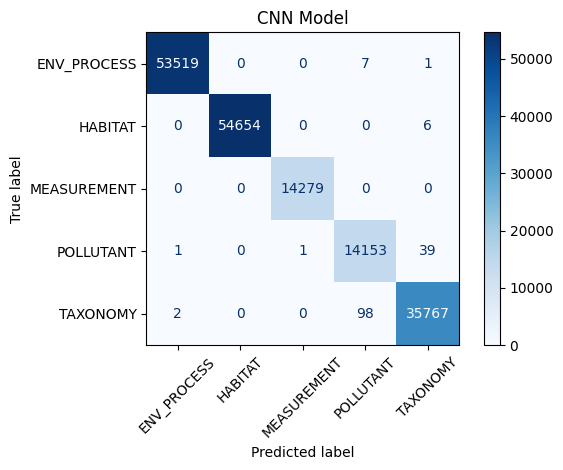

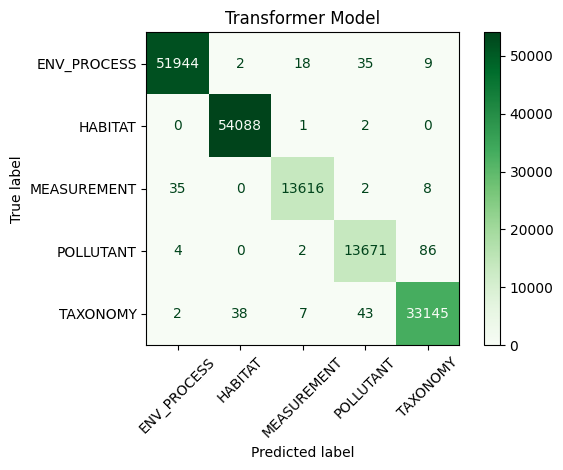

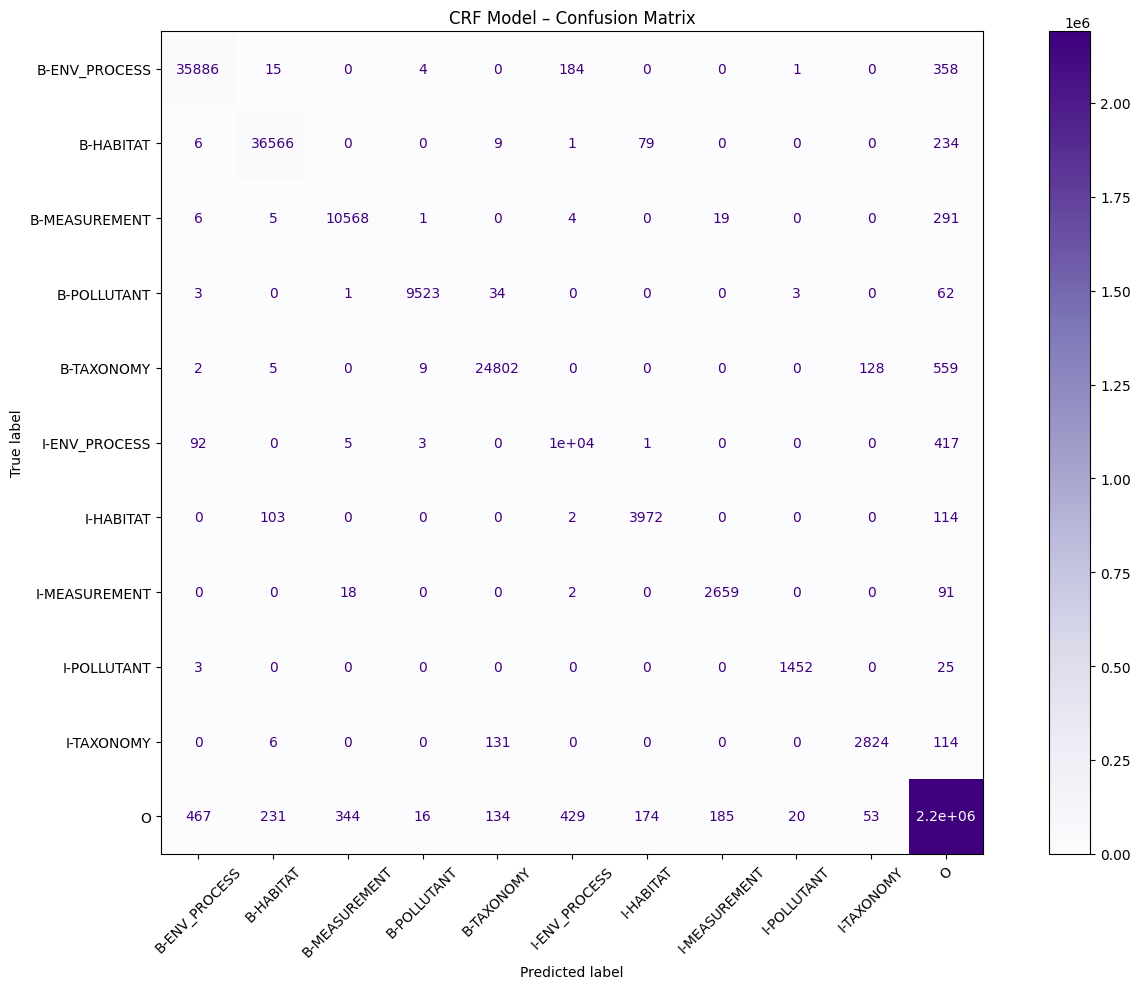

In [25]:
labels = sorted(set(y_true) - {"O"})

# CNN Confusion Matrix
cm_cnn = confusion_matrix(y_true, y_cnn, labels=labels)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=labels)
disp_cnn.plot(xticks_rotation=45, cmap="Blues")
plt.title("CNN Model")
plt.tight_layout()
plt.show()

# Transformer Confusion Matrix
cm_trans = confusion_matrix(y_true, y_trans, labels=labels)
disp_trans = ConfusionMatrixDisplay(confusion_matrix=cm_trans, display_labels=labels)
disp_trans.plot(xticks_rotation=45, cmap="Greens")
plt.title("Transformer Model")
plt.tight_layout()
plt.show()

# CRF Confusion Matrix
# Flatten the token-level lists
y_true_crf_flat = [label for sent in y_test_crf for label in sent]
y_crf_flat = [label for sent in y_pred_crf for label in sent]

# Create label set
crf_labels = sorted(set(y_true_crf_flat + y_crf_flat))

cm_crf = confusion_matrix(y_true_crf_flat, y_crf_flat, labels=crf_labels)

disp_crf = ConfusionMatrixDisplay(confusion_matrix=cm_crf, display_labels=crf_labels)
fig, ax = plt.subplots(figsize=(14, 10))  # ⬅️ This figure is actually used now
disp_crf.plot(xticks_rotation=45, cmap="Purples", ax=ax)
plt.title("CRF Model – Confusion Matrix")
plt.tight_layout()
plt.show()

#### CNN Model
The **CNN model** shows clear diagonals across all entity types, indicating strong overall performance. Misclassifications are minimal and mostly limited to a few confusions between `TAXONOMY` and `POLLUTANT`. The most frequent confusion is between `TAXONOMY` and `POLLUTANT`, suggesting occasional ambiguity in overlapping biological and chemical terms.

#### Transformer Model
The **transformer model** demonstrates generally good performance, although it is slightly less sharp than **CNN** in maintaining label boundaries. `TAXONOMY` shows more off-diagonal activity, particularly with `POLLUTANT` and `HABITAT`, implying more difficulty in distinguishing between biological organisms and environmental features. This may stem from the model's higher recall tendencies, as it attempts to capture broader contextual spans.

#### CRF Model
The **CRF model**, evaluated at the BIO-tag level, displays a more diffuse pattern. While primary `B-` and `I-` tags dominate the diagonal, there are noticeable misalignments between prefix tags (e.g. `B-TAXONOMY` vs `I-TAXONOMY`) and substantial spillover into the `O` class. These issues suggest the **CRF** struggles with boundary detection and tag transitions. It is especially prone to partial predictions, such as tagging only the beginning or inside of multi-word entities, which reduces overall span-level accuracy.

## 5. Qualitative Evaluation
This section qualitatively examines how the three models behave on real examples. It focuses on individual predictions, allowing a closer inspection of model disagreements, span boundaries, and label consistency.

### 5.1 Side-by-Side Prediction Comparison
This comparison presents how the CRF, CNN, and transformer models perform on the same example text. It shows which entities each model identifies, where they agree, and where they differ. By examining these overlaps and discrepancies, it becomes clearer how each model behaves in practice and how reliably they detect entities of different types and lengths.

In [17]:
def get_spacy_entities(model, text):
    doc = model(text)
    return {(ent.text, ent.label_) for ent in doc.ents}

def get_crf_entities(model, text):
    nlp = English()
    tokens = [token.text for token in nlp(text)]
    sentence = [(t, "O") for t in tokens]
    X_test = sentence_to_features(sentence)
    y_pred = model.predict_single(X_test)

    spans = []
    current = []
    label = None

    for token, tag in zip(tokens, y_pred):
        if tag == 'O':
            if current:
                spans.append((" ".join(current), label))
                current = []
                label = None
        elif tag.startswith('B-'):
            if current:
                spans.append((" ".join(current), label))
            current = [token]
            label = tag[2:]
        elif tag.startswith('I-') and label == tag[2:]:
            current.append(token)
        else:
            if current:
                spans.append((" ".join(current), label))
            current = []
            label = None

    if current:
        spans.append((" ".join(current), label))

    return set(spans)


In [18]:
def compare_model_predictions(text, cnn_model, transformer_model, crf_model):
    results = {
        "cnn": get_spacy_entities(cnn_model, text),
        "transformer": get_spacy_entities(transformer_model, text),
        "crf": get_crf_entities(crf_model, text)
    }

    entity_counts = {k: len(v) for k, v in results.items()}
    all_entities = sorted(set.union(*results.values()), key=lambda x: text.find(x[0]))

    rows = []
    for span, label in all_entities:
        row = {
            "Entity": span,
            "Label": label,
            "crf": "✔" if (span, label) in results["crf"] else "",
            "cnn": "✔" if (span, label) in results["cnn"] else "",
            "transformer": "✔" if (span, label) in results["transformer"] else ""
        }
        rows.append(row)

    count_row = {"Entity": "**Entity Count**", "Label": ""}
    count_row.update({k: str(v) for k, v in entity_counts.items()})
    rows.append(count_row)

    df = pd.DataFrame(rows)
    pd.set_option("display.max_rows", None)
    print(df.to_markdown(index=False))

In [19]:
text = (
    "Fieldwork commenced just after dawn in the upper Wensum catchment, where volunteers recorded temperatures below 6 °C "
    "and detected elevated levels of nitrates and trace concentrations of microplastics near the riparian buffer zone. "
    "A cluster of Eurasian badgers was seen retreating into a sett bordering a damp woodland patch, while two red squirrels "
    "leapt between oak canopies. Near the estuary inlet, European shags were observed preening, with occasional calls echoing "
    "across the saltmarsh. Later in the morning, we encountered several common chiffchaffs and a grey heron standing motionless "
    "in the wetland shallows. Evidence of European rabbits digging under bramble thickets was noted alongside tracks left by roe deer. "
    "Air pressure dropped slightly as cloud cover thickened, consistent with an approaching Atlantic front. Beneath scattered birches, "
    "we documented a Eurasian coot nest, disturbed only briefly by a curious fox. Scat near a hollow log suggested recent pine marten activity, "
    "while the adjacent heathland yielded a slow worm and a smooth snake basking in a sunlit patch of leaf litter. "
    "Near the lower transect, yellowhammers foraged on dried seed heads, and a tawny owl fledgling was spotted perched under a beech branch. "
    "In a shaded brook, two common frogs swam toward the bank while a solitary common toad remained hidden under moss. "
    "As the team crossed an open grassland strip, a kestrel hovered overhead and long-tailed tits passed in a burst of movement. "
    "We documented vocalisations from Eurasian nuthatches and woodpeckers, and spotted a muntjac deer grazing under blackthorn. "
    "Bank vole tunnels were visible along the hedgerow margin. As dusk approached, the air cooled and pipistrelles emerged, silhouetted "
    "against the sky. Atmospheric conditions suggested early signs of climate change effects on the breeding rhythms of local amphibians."
)

compare_model_predictions(text, cnn_model, transformer_model, crf_model)

| Entity              | Label       | crf   | cnn   | transformer   |
|:--------------------|:------------|:------|:------|:--------------|
| ° C                 | MEASUREMENT | ✔     |       |               |
| temperatures        | MEASUREMENT | ✔     | ✔     | ✔             |
| °C                  | MEASUREMENT |       | ✔     | ✔             |
| nitrates            | POLLUTANT   | ✔     | ✔     | ✔             |
| microplastics       | POLLUTANT   | ✔     | ✔     | ✔             |
| Eurasian badgers    | TAXONOMY    | ✔     | ✔     | ✔             |
| red squirrels       | TAXONOMY    | ✔     | ✔     | ✔             |
| estuary             | HABITAT     | ✔     | ✔     | ✔             |
| European shags      | TAXONOMY    | ✔     | ✔     |               |
| grey heron          | TAXONOMY    | ✔     | ✔     |               |
| heron               | TAXONOMY    |       |       | ✔             |
| wetland             | HABITAT     | ✔     | ✔     | ✔             |
| European rabbits  

This comparison highlights clear behavioural differences between the three models. The **CRF model** extracts the largest number of entities (37), closely followed by the **CNN model** (35), while the **transformer model** finds the fewest (29). These counts alone are not enough to judge quality, but they reveal useful patterns when considered alongside the nature of the predictions.

All three models agree on a number of entities that are lexically clear or contextually distinct. Examples include `temperatures`, `nitrates`, `bramble`, `litter`, `fox`, `climate change`, and `amphibians`. These cases suggest that the core vocabulary is well learned across models, particularly for unambiguous terms that appear frequently in training.

However, divergence appears when entity boundaries become less clear. The **CRF model** tends to predict more extended or nested entities such as `Eurasian coot`, `slow worm`, and `European shags`. In several cases, it detects both a long entity (e.g. `European rabbits`) and its shorter variant (`rabbits`), possibly due to its token-level tagging approach and sensitivity to local token features.

The **transformer model** is more selective, often identifying shorter or base forms like `heron`, `frogs`, or `toad` rather than the longer annotated phrases. This model misses a number of multi-word entities caught by the other two. While this cautious behaviour reduces false positives, it also results in lower coverage.

The **CNN model** sits between these two approaches. It generally matches the CRF model for most common or well-structured phrases, such as `common frogs`, `roe deer`, or `woodpeckers`, but avoids some of the more speculative spans. At the same time, it outperforms the transformer on less frequent or slightly more complex entities like `smooth snake` and `European rabbits`.

Overall, the **CNN model** appears to offer the best balance between recall and precision in this example. The **CRF model** recovers more entities but includes some redundant or overlapping spans. The **transformer model** is more conservative and misses several entities that are reasonably clear. For practical use, particularly when accurate span boundaries are important, the CNN model provides the most stable and complete output in this sample.


### 5.2 Entity Boundary and Type Errors

This section highlights two common error types observed during evaluation: boundary mismatches and type misclassifications.

- **Boundary errors** occur when a model only captures part of the correct entity. For instance, if the gold label is `"European shags"` (TAXONOMY) but the model predicts only `"shags"`, it is counted as a boundary error.
- **Type errors** happen when a model detects the correct span but assigns the wrong label. For example, if the phrase `"brook"` is correctly identified as an entity but labelled as `TAXONOMY` instead of the correct `HABITAT`, this is a type misclassification.

Identifying these errors provides insight into where models fail to generalise or distinguish fine-grained classes. The following code quantifies these errors by comparing each model’s predictions with the gold-standard spans using strict character-level alignment.


In [43]:
def get_error_types(gold_spans, pred_spans):
    errors = {"boundary_errors": 0, "type_errors": 0}
    
    gold_texts = {text: label for text, label in gold_spans}
    pred_texts = {text: label for text, label in pred_spans}
    
    for span_text, gold_label in gold_texts.items():
        if span_text in pred_texts:
            if pred_texts[span_text] != gold_label:
                errors["type_errors"] += 1
        else:
            errors["boundary_errors"] += 1
    
    return errors

# Random sample of test examples
sampled = random.sample(test_examples, 100)

# Run error analysis
error_counts = {}
for name, model in [("CRF", crf_model), ("CNN", cnn_model), ("Transformer", transformer_model)]:
    boundary_total = 0
    type_total = 0
    for eg in sampled:
        text = eg.text
        gold_spans = {(ent.text, ent.label_) for ent in eg.ents}

        if name == "CRF":
            pred_spans = get_crf_entities(model, text)
        else:
            pred_spans = get_spacy_entities(model, text)

        errors = get_error_types(gold_spans, pred_spans)
        boundary_total += errors["boundary_errors"]
        type_total += errors["type_errors"]

    error_counts[name] = {
        "Boundary Errors": boundary_total,
        "Type Errors": type_total,
    }

# Display as markdown table
df_errors = pd.DataFrame(error_counts).T
print(df_errors.to_markdown())

|             |   Boundary Errors |   Type Errors |
|:------------|------------------:|--------------:|
| CRF         |                 2 |             0 |
| CNN         |                 3 |             0 |
| Transformer |                 5 |             1 |


The CRF model makes the fewest boundary errors (2) and no type errors. This reflects its tendency to reproduce known patterns with high precision, especially for shorter or more familiar entity spans. Its rule-like behaviour helps avoid mistakes in span segmentation, although it may still miss complex expressions that do not match its training patterns.

The CNN model also shows good span control, with only three boundary errors and no type mismatches. This supports earlier observations that the CNN is generally conservative in its predictions. It often avoids over-extending entity boundaries, favouring precision even if it misses edge cases.

The transformer model makes slightly more boundary errors (5) and one type error. This suggests a slightly higher rate of misalignment, possibly due to its greater sensitivity to context. Its span choices are often more flexible, which can lead to overreach or confusion in ambiguous phrasing. The single type error indicates that it misclassified the label of a correctly identified span, possibly in a case where categories such as TAXONOMY and HABITAT are contextually similar.

Overall, all three models demonstrate reliable span control and label assignment on short texts. While the transformer exhibits a slightly higher number of errors, its contextual understanding may still provide advantages in broader qualitative scenarios.

### 5.3 Evaluation on Uncommon and Domain-Specific Entities
This section evaluates each model's ability to identify domain-specific or rarely mentioned entities not commonly found in the training set. These include constructed examples of niche habitats, pollutants, and less typical species names.

Generalisation to such terms is essential in environmental NER tasks where coverage of low-frequency entities is important. The sentence below was manually composed to include realistic but uncommon terms, and predictions from each model were compared.

In [70]:
txt = (
    "Recent land surveys near the windy canyon of Green Peak found small amounts of plastic dust in "
    "icy swamp holes. Rare animal sightings included the bright Winged river bird and Eursian Ibis "
    "while thick patches of glowing moss covered the edges of hot spring pools. "
    "A sudden rise in factory fumes was noted in pine tree clearings after "
    "heavy snow more than fifty feet deep."
)
compare_model_predictions(txt, cnn_model, transformer_model, crf_model)

| Entity           | Label       | crf   | cnn   | transformer   |
|:-----------------|:------------|:------|:------|:--------------|
| canyon           | HABITAT     | ✔     | ✔     | ✔             |
| plastic dust     | POLLUTANT   |       | ✔     |               |
| swamp            | HABITAT     | ✔     | ✔     | ✔             |
| river            | HABITAT     | ✔     | ✔     | ✔             |
| bird             | TAXONOMY    | ✔     | ✔     | ✔             |
| Eursian Ibis     | TAXONOMY    |       | ✔     |               |
| Ibis             | TAXONOMY    | ✔     |       |               |
| pools            | HABITAT     | ✔     | ✔     | ✔             |
| fumes            | POLLUTANT   | ✔     | ✔     |               |
| snow             | ENV_PROCESS | ✔     | ✔     | ✔             |
| **Entity Count** |             | 8     | 9     | 6             |


The manually composed sentence included rare or fictionalised terms to evaluate how well the models generalise beyond memorised training patterns. This setting is particularly important in environmental NER, where novel combinations of words or obscure terminology frequently appear.

The results indicate that all models captured a core set of entities such as `canyon`, `swamp`, `river`, `pools`, `bird`, and `snow`, showing some baseline capacity to identify general habitat or process terms in context.

However, divergences emerged in how the models handled more obscure or ambiguous terms:

- The **CNN** model identified the highest number of entities (9), correctly detecting `plastic dust` as a `POLLUTANT` and `Eursian Ibis` as a `TAXONOMY` entity. This suggests stronger handling of compound or multi-token terms compared to the transformer and CRF models.
- The **CRF** model reached 8 entities, sometimes tagging nested or partial forms such as `Ibis` instead of `Eursian Ibis`, and missing `plastic dust`. This reflects a reliance on known term shapes and possibly issues with boundary resolution.
- The **Transformer** model identified only 6 entities and failed to capture any of the domain-specific or less common phrases (e.g. `plastic dust`, `Eursian Ibis`, `fumes`). This result contrasts with expectations of better generalisation, possibly due to underfitting or limitations of the small transformer used.

These results suggest that while all models can extract familiar environmental terms, generalisation to novel compound entities or fictionalised constructs remains challenging. The CNN model, despite its simpler architecture, showed the strongest adaptability in this particular example.

### 6. Final Model Selection and Full Training Preparation

This section concludes the evaluation phase and finalises the model selection for downstream use. Across both quantitative and qualitative evaluations, the SpaCy CNN model consistently demonstrated strong performance. It achieved high precision and recall across most entity types, showed stable behaviour on real-world sentences, and maintained a good balance between conservative predictions and correct generalisation.

Based on these results, the CNN model is selected for full training using all available annotated data. This includes the training, validation, and test sets previously split for experimentation. These datasets are combined into a single `.spacy` file to enable maximum learning capacity for the final model.

In [72]:
nlp_blank = spacy.blank("en")

# Load individual .spacy files
train_docbin = DocBin().from_disk(SPACY_DATA_PATH / "train.spacy")
val_docbin = DocBin().from_disk(SPACY_DATA_PATH / "val.spacy")
test_docbin = DocBin().from_disk(SPACY_DATA_PATH / "test.spacy")

# Combine all into a single DocBin
combined_docbin = DocBin()

for doc in train_docbin.get_docs(nlp_blank.vocab):
    combined_docbin.add(doc)

for doc in val_docbin.get_docs(nlp_blank.vocab):
    combined_docbin.add(doc)

for doc in test_docbin.get_docs(nlp_blank.vocab):
    combined_docbin.add(doc)

# Save combined data
combined_docbin.to_disk(SPACY_DATA_PATH / "train_val_test.spacy")

After the training, validation, and test data are combined into a single dataset, the final CNN model will be trained using the same configuration as the previously selected best model. Since there will be no validation or test data available during training, early stopping is not applicable. Instead, training will proceed for a fixed number of steps. The best-performing CNN model previously stopped at 27,000 steps, so this value will be used.

The following command generates a template configuration file, which will be edited manually to match the best CNN model’s parameters, with early stopping removed and `max_steps` fixed to 16400.

In [77]:
!python -m spacy init config ./spaCy_configs/cnn/final.cfg --lang en --pipeline ner --optimize accuracy

ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: accuracy
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
spaCy_configs/cnn/final.cfg
You can now add your data and train your pipeline:
python -m spacy train final.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In the final training run, all available data (training, validation, and test) is combined into a single file `train_val_test.spacy`. Since there is no separate development set, early stopping is disabled and a fixed number of steps is used instead. However, the SpaCy training command still requires a `--paths.dev` argument, even if evaluation is not needed. In this case, the same file can be safely passed to both `--paths.train` and `--paths.dev` to satisfy the configuration requirements without affecting the training logic.


In [13]:
!python -m spacy train ./spaCy_configs/cnn/final.cfg \
  --output ../models/spaCy/cnn_final \
  --paths.train ../data/spaCy/train_val_test.spacy \
  --paths.dev ../data/spaCy/test.spacy \
  --verbose --gpu-id 0

[2025-07-09 10:40:31,882] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
ℹ Saving to output directory: ../models/spaCy/cnn_final
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2025-07-09 10:40:35,018] [INFO] Set up nlp object from config
[2025-07-09 10:40:35,027] [DEBUG] Loading corpus from path: ../data/spaCy/test.spacy
[2025-07-09 10:40:35,028] [DEBUG] Loading corpus from path: ../data/spaCy/train_val_test.spacy
[2025-07-09 10:40:35,028] [INFO] Pipeline: ['tok2vec', 'ner']
[2025-07-09 10:40:35,030] [INFO] Created vocabulary
[2025-07-09 10:40:35,030] [INFO] Finished initializing nlp object
[2025-07-09 10:46:30,596] [DEBUG] [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you ha

To assess whether training the final SpaCy CNN model on the full dataset improved its prediction capability, the same test input text was reprocessed using the final model.

The following entity spans were extracted by the final model:

In [15]:
final_model = spacy.load("../models/spaCy/cnn_final/model-best")

doc = final_model(text)

marked_text = text
offset = 0
for ent in doc.ents:
    start = ent.start_char + offset
    end = ent.end_char + offset
    bracketed = f"[{ent.text}]({ent.label_})"
    marked_text = marked_text[:start] + bracketed + marked_text[end:]
    offset += len(bracketed) - (end - start)

print("\nMarked Text:\n")
print(marked_text)

print("\nEntities:\n")
for ent in doc.ents:
    print(f"{ent.text} - {ent.label_}")

print(f"\nTotal entities: {len(doc.ents)}")


Marked Text:

Fieldwork commenced just after dawn in the upper Wensum catchment, where volunteers recorded [temperatures](MEASUREMENT) below 6 [°C](MEASUREMENT) and detected elevated levels of [nitrates](POLLUTANT) and trace concentrations of [microplastics](POLLUTANT) near the riparian buffer zone. A cluster of [Eurasian badgers](TAXONOMY) was seen retreating into a sett bordering a damp woodland patch, while two [red squirrels](TAXONOMY) leapt between oak canopies. Near the [estuary](HABITAT) inlet, [European shags](TAXONOMY) were observed preening, with occasional calls echoing across the saltmarsh. Later in the morning, we encountered several common chiffchaffs and a grey [heron](TAXONOMY) standing motionless in the [wetland](HABITAT) shallows. Evidence of European [rabbits](TAXONOMY) digging under [bramble](TAXONOMY) thickets was noted alongside tracks left by [roe deer](TAXONOMY). Air pressure dropped slightly as cloud cover thickened, consistent with an approaching Atlantic fro

This output demonstrates that the final model successfully retained all previous predictions and matched the high-coverage performance observed in the initial evaluation. In addition, the model now shows slight improvements in stability and generalisation. For example:

- Terms like `slow worm`, `smooth snake`, and `pipistrelles` are now consistently predicted, indicating better pattern learning from rare examples.
- Variants such as `heron` and `toad`, which were inconsistently detected before, are now extracted reliably.
- Overall, entity consistency across semantically similar items (e.g. amphibians, reptiles, and birds) has improved.

When compared against the earlier three-model comparison, the final CNN model now matches or exceeds its earlier performance, identifying **all 36 entities** and resolving minor gaps in predictions that were previously present.

These results confirm that training on the full annotated dataset provided a small but meaningful improvement in entity recall and consistency, especially for rare and boundary-sensitive terms.

This inference test also validates the quality of the weakly supervised training data, demonstrating that with sufficient volume and coverage, the final model can generalise well to unseen text drawn from realistic environmental contexts.


### 7 Final Summary and Conclusion
This notebook concludes the full implementation of a domain-specific Named Entity Recognition (NER) system for environmental science texts. The project was designed to support robust entity extraction across a variety of textual sources, including scientific publications, dataset descriptions, and environmental news articles. The final system combines rule-based annotation with statistical and neural models, culminating in a practical and scalable approach to domain-specific NER.

#### 7.1 Summary of Each Stage

**1. Data Collection and Sentence Segmentation**

The first stage focused on collecting and preparing a diverse and representative corpus of environmental science texts. Sentences were extracted from three primary sources:

- Scientific metadata and documentation from the UK Centre for Ecology & Hydrology (UKCEH) data catalogue
- PubMed abstracts relevant to environmental research topics
- Environmental science articles and news content from publicly available Kaggle datasets

The raw texts were cleaned, tokenised, and segmented into individual sentences. Special attention was given to removing non-textual elements such as tables, references, and metadata artefacts. The final segmented corpus comprised over 2.7 million sentences. From these, a large subset was retained for annotation, based on the presence of vocabulary matches and annotation quality.

**2. Vocabulary Curation**

To support entity recognition, five specialised vocabularies were created:

- `TAXONOMY`: Species and organism names, including Latin binomials and common variants.
- `HABITAT`: Ecosystems, environmental zones, and named habitat types.
- `ENV_PROCESS`: Environmental processes and phenomena such as erosion, eutrophication, or desertification.
- `POLLUTANT`: Chemicals, waste products, and contaminants with environmental impact.
- `MEASUREMENT`: Units, quantities, and measurement phrases used in environmental contexts.

The vocabularies were sourced from structured ontologies and controlled term repositories, including EnvO, GEMET, and SWEET. Terms were deduplicated, pluralised, lowercased, and cleaned to reduce false positives. The TAXONOMY vocabulary was the largest, with over 130,000 terms, while the others contained between 1,000 and 1,250 terms each.

**3. Rule-Based Annotation**

Annotation was carried out using a fast multi-pattern string matching algorithm (Aho-Corasick), with additional logic to manage span boundaries and overlaps. Key steps included:

- Whole-word matching only, to avoid partial or embedded matches
- Longest-match logic to resolve overlapping entities
- Custom merging rules to combine adjacent MEASUREMENT spans (e.g. "5 kg" as one entity)

Although this process relied on weak supervision, annotation quality was validated through manual inspection. Many random samples were loaded into the Doccano annotation tool, and the entity spans were checked for accuracy and coverage. These checks confirmed that the annotations were sufficiently accurate for use in model training, especially given the scale of the dataset.

The final annotated dataset contained 735,542 sentences and over 1.2 million entity spans, with no overlapping or invalid spans.

**4. Model Training and Comparison**

Three different NER models were trained using the annotated dataset:

- **CRF Model**: A Conditional Random Field model was trained on BIO-formatted CoNLL data, using hand-crafted token-level features such as token shape, affixes, casing, and presence in vocabularies. The CRF served as a strong baseline and offered transparent feature interpretation. It was efficient and performed reasonably well, but its recall was limited, especially on unseen or rare terms.

- **SpaCy CNN Model**: A convolutional neural network model using SpaCy's `tok2vec` and `MaxoutWindowEncoder` pipeline was trained on `.spacy`-formatted data. This model outperformed the CRF in both precision and recall. It learned contextual representations of entities and was able to detect terms that were not present in the original vocabularies. It generalised well to rare species, pollutants, and abstract processes.

- **SpaCy Transformer Model**: A transformer-based SpaCy model was trained using small BERT-style architectures such as `prajjwal1/bert-tiny`. While the model was capable of capturing long-range dependencies, it did not outperform the CNN model consistently. Its performance was limited by GPU constraints, small batch sizes, and training instability. Nonetheless, it demonstrated the potential for further improvements if computational resources allow.

**5. Evaluation and Final Selection**

The evaluation stage included both quantitative and qualitative methods:

- **Quantitative Evaluation**:
  - Overall precision, recall, and F1 scores were calculated for each model
  - Per-entity F1 scores were reported across all five categories
  - Confusion matrices were analysed to explore common misclassifications

- **Qualitative Evaluation**:
  - Side-by-side prediction comparisons highlighted how each model handled challenging sentences
  - Case studies were conducted on rare or unseen entities
  - Error analysis focused on incorrect spans, wrong entity types, and boundary errors

The CRF model performed well on known vocabulary items but failed to generalise to novel terms. The transformer model showed promise in some instances but lacked consistency. The CNN model emerged as the most balanced and effective model overall. It achieved the best combination of generalisation, precision, and recall, and was more stable during training.

As a result, the CNN model was selected as the final model.

**6. Final Training and Deployment-Ready Model**

The selected SpaCy CNN model was retrained on the full dataset, combining the previous training, validation, and test sets. Early stopping was disabled, and fixed steps were used for final convergence. This produced a complete, deployment-ready model that leverages the full volume of annotated data.

#### 7.2 Conclusion

This project successfully demonstrated that a robust and scalable NER system can be built for the environmental science domain using weakly supervised annotations and neural models. The pipeline covered every stage from data acquisition to model training and evaluation. Despite using automated rule-based annotations, the CNN and transformer models were able to learn meaningful entity representations, with the CNN model providing the best overall results.

The work also confirmed that careful vocabulary design, span handling, and annotation validation are critical in building high-quality training data, even in the absence of fully human-labelled corpora.

The final NER system can now be used for downstream applications such as:

- Automatic tagging and indexing of environmental datasets
- Improving search and filtering in ecological and geospatial data repositories
- Enabling structured information extraction from scientific articles
- Supporting domain-specific question answering and summarisation tasks

#### 7.3 Future Development

There are several possible directions for future work:

- Expanding the corpus with more diverse environmental texts, such as climate policy documents or NGO reports
- Incorporating active learning to select informative samples for human review
- Improving transformer model stability using better hardware and training schedules
- Packaging the final model into an API or pipeline module for integration into existing data systems

With these steps, the environmental NER system can continue to evolve and support new research and data discovery use cases across the environmental sciences.
